In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [3]:
excel_file = 'Data/Soil_data/2018 Fertility yield and soils for input.xlsx' 
sheet_names = ['16A', '6-12', 'SW16', 'Y8', 'Y10']

df = pd.DataFrame()
for sheet in sheet_names:
    df_sheet = pd.read_excel(excel_file, sheet_name=sheet, engine='openpyxl')
    df_sheet['Depth'] = df_sheet['Depth'] + '"'
    df = pd.concat([df, df_sheet])

df.to_csv('Data/Soil_data/2018_combined_sheets.csv', index=False)

In [4]:
# Original code
df_subset = df.copy()
df_subset = df_subset[df_subset['Depth'] == '0-6"']

# Create a dictionary for renaming FieldID
rename_dict = {
    "16A": "Field 1",
    "6-12": "Field 2",
    "SW16": "Field 3",
    "Y10": "Field 4",
    "Y8": "Field 5"
}

# Rename the FieldID column based on the provided mapping
# df_subset['FieldID'] = df_subset['FieldID'].replace(rename_dict)

# Continue with the original code
ord_data = df_subset.loc[:, 'TOC':'Ols Zn']
ord_data = ord_data[['TOC', 'TC', 'IC', 'TN', 
                           'DI Al', 'DI Ca', 'DI Fe', 'DI K', 'DI Mg', 'DI P', 
                           'H3A Al', 'H3A Ca', 'H3A Fe', 'H3A K', 'H3A Mg', 'H3A P',
                           'M3 Al', 'M3 Ca', 'M3 Fe', 'M3 K', 'M3 Mg', 'M3 P',
                           'Ols Al', 'Ols Ca', 'Ols Fe', 'Ols K', 'Ols Mg', 'Ols P']]


ord_data = ord_data.fillna(0)
ord_data.head()

TOC          TC         IC         TN  DI Al   DI Ca  DI Fe   DI K  \
2   167.021633  201.380237  34.358604  15.557045  534.0  2180.0   93.6  161.8   
5   169.482299  245.773704  76.291405  19.246572  486.0  3340.0   52.0  344.0   
8   164.392799  213.915403  49.522604  19.204573  524.0  2300.0   93.8  171.6   
11  162.531049  247.750409  85.219360  22.604458  456.0  3380.0   56.2  318.0   
14  143.217097  198.484583  55.267486  14.389380  514.0  2340.0  103.0  181.2   

    DI Mg   DI P  ...  M3 Fe   M3 K  M3 Mg  M3 P  Ols Al  Ols Ca  Ols Fe  \
2   236.0  16.08  ...  105.0  241.0    236  17.0    1.22   193.0    1.02   
5   155.6  14.00  ...   58.2  511.0    157  14.8    1.14   115.0    1.28   
8   214.0  17.48  ...  106.0  258.0    215  18.7    1.63   164.0    1.52   
11  151.0  10.82  ...   63.6  473.0    152  11.2    1.64    99.2    1.39   
14  208.0  18.92  ...  117.0  274.0    210  20.2    1.90   150.0    2.95   

    Ols K  Ols Mg  Ols P  
2   172.0    78.4   4.95  
5   266.0    33.1   4.86  
8   171.0    64.3   6.18  
11  233.0    30.2   5.20  
14  196.0    62.0   6.75  

[5 rows x 28 columns]

/tmp/ipykernel_525/1198796992.py:17: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x[idx], y[idx], c=color, label=field_id)


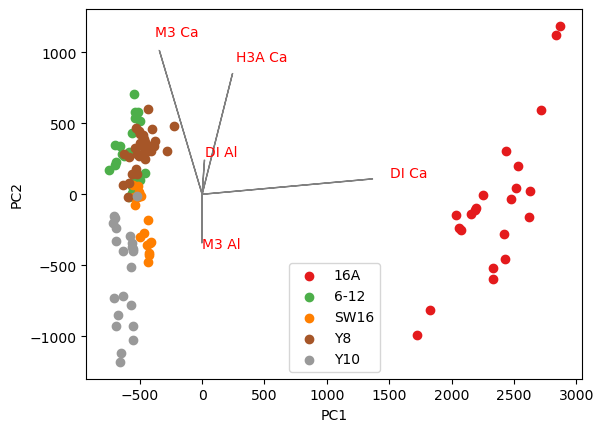

In [5]:
# Perform PCA
pca = PCA(n_components=2)
pca.fit(ord_data)
PCA_coords = pca.transform(ord_data)

x = PCA_coords[:, 0]
y = PCA_coords[:, 1]

# Create a colormap for unique Field IDs
colormap = plt.cm.Set1
field_colors = [colormap(i) for i in np.linspace(0, 1, len(df_subset.FieldID.unique()))]
field_map = dict(zip(df_subset.FieldID.unique(), field_colors))

# Plot the PCA points colored by FieldID
for field_id, color in field_map.items():
    idx = df_subset.FieldID == field_id
    plt.scatter(x[idx], y[idx], c=color, label=field_id)

# Calculate the lengths of loading vectors
vector_lengths = np.sqrt(pca.components_[0, :]**2 + pca.components_[1, :]**2)

# Identify the indices of the five longest vectors
top_indices = vector_lengths.argsort()[-5:][::-1]

# Add arrows for top loading vectors
scale_factor = max(x.max() - x.min(), y.max() - y.min()) / 2.5
for i in top_indices:
    plt.arrow(0, 0, pca.components_[0, i] * scale_factor, pca.components_[1, i] * scale_factor,
              color='gray', width=0.005, head_width=0.05)
    plt.text(pca.components_[0, i] * scale_factor * 1.1, pca.components_[1, i] * scale_factor * 1.1,
             ord_data.columns[i], color='red')

# Add labels and legend
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='best')
plt.savefig('Output/Figures/Soil_ordination.jpg', bbox_inches = 'tight', dpi = 300)

In [6]:
# Extract top variable names from the original dataset based on top_indices
top_variables = ord_data.columns[top_indices]

# Group by FieldID and calculate mean and standard deviation for the top variables
grouped = df_subset.groupby('FieldID')[top_variables]
summary_df = grouped.agg(['mean', 'std'])

summary_df

DI Ca                    M3 Ca                   H3A Ca  \
                mean         std         mean         std         mean   
FieldID                                                                  
16A      2950.000000  435.813416  3093.636364  486.332685  2431.236364   
6-12      229.500000   58.754463  4138.333333  178.317418  2021.666667   
SW16      200.500000   15.382381  3603.333333  202.542661  2039.444444   
Y10       118.431818   56.967839  3485.000000  266.721721  1669.090909   
Y8        328.637500   97.367471  3998.750000   93.247849  2121.250000   

                          M3 Al                   DI Al              
                std        mean         std        mean         std  
FieldID                                                              
16A      787.309047  302.650000  140.590421  375.900000  133.901709  
6-12     149.307581  177.350000   66.592551  280.345833  128.843690  
SW16      57.850947  379.777778   59.652479  253.277778   43.168351  
Y10      225.745518  487.818182   66.013445  256.863636  181.781212  
Y8        71.965494  204.312500   58.570298  541.875000  177.347254

In [7]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [8]:
# For 'DI Ca'
formula_DI_Ca = 'Q("DI Ca") ~ C(FieldID)'
model_DI_Ca = ols(formula_DI_Ca, data=df_subset).fit()
anova_table_DI_Ca = sm.stats.anova_lm(model_DI_Ca, typ=2)

# For 'M3 Al'
formula_M3_Al = 'Q("M3 Al") ~ C(FieldID)'
model_M3_Al = ols(formula_M3_Al, data=df_subset).fit()
anova_table_M3_Al = sm.stats.anova_lm(model_M3_Al, typ=2)

print("ANOVA for 'DI Ca':")
print(anova_table_DI_Ca)
print("\nANOVA for 'M3 Al':")
print(anova_table_M3_Al)


ANOVA for 'DI Ca':
                  sum_sq     df           F        PR(>F)
C(FieldID)  1.328583e+08    4.0  846.457222  3.258078e-83
Residual    4.434066e+06  113.0         NaN           NaN

ANOVA for 'M3 Al':
                  sum_sq     df          F        PR(>F)
C(FieldID)  1.543589e+06    4.0  56.235431  5.082102e-26
Residual    7.754253e+05  113.0        NaN           NaN
